In [1]:
from scipy.fftpack import dctn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure


# ESTIMATE IMAGE NOISE

(849, 1280)

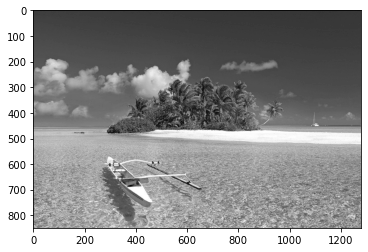

In [2]:
im = np.array(Image.open("paysages/beach.jpg"))
im = np.array(im).mean(axis=2) # convert to bw
plt.imshow(im, cmap='gray')
im.shape

In [4]:
# PONA uniform

def dct_variance(d,mask):
    '''input: d (dct of the block), mask (0 1 array, non null coefficient) output: variance of the block'''
    d = d*mask
    d = d*d
    return np.sum(d)/np.sum(mask)


def create_mask(k,T):
    mask = np.zeros((k,k))
    for i in range(k):
        for j in range(k):
            if (i+j!=0 and i+j<T):
                mask[i,j]=1
    return mask



def find_uniform_std(arr, k=8, T=8, stride=8):
    n,m = arr.shape
    L=[]
    mask = create_mask(k,T)

    for i in range(0,n-k,stride):
        for j in range(0,m-k,stride):
            dm = dctn(arr[i:i+k,j:j+k],norm='ortho')
            L.append((dm, dct_variance(dm,mask)))
    return process_result(L,mask)

def process_result(L,mask):
    L.sort(key=lambda el: el[1]) #sort blocks according to their variance
    mask = 1-mask
    mask[0,0]=0
    m = np.zeros_like(mask)
    n_g = int(len(L)*0.005)
    for i in range(n_g):
        m += (L[i][0]*mask)**2
    d= m/(n_g)

    k = 8
    var_list = []
    for i in range(k):
        for j in range(k):
            if mask[i,j]:
                var_list.append(d[i,j])
    return np.sqrt(np.median(np.array(var_list)))

im = np.array(Image.open("paysages/beach.jpg"))
im = np.array(im).mean(axis=2) # convert to bw
im += 110*np.random.normal(size=im.shape)
L = find_uniform_std(im)
L

109.14024495782321

In [12]:



def find_value_std(arr, k=8, T=8, stride=8, bins=20):
    n,m = arr.shape
    L=[[] for _ in range(bins)]
    mask = create_mask(k,T)

    for i in range(0,n-k,stride):
        for j in range(0,m-k,stride):
            dm = dctn(arr[i:i+k,j:j+k],norm='ortho')
            index = int(dm[0,0]/k*bins/255)
            L[index].append((dm, dct_variance(dm,mask))) # block/variance/mean

    L2 = []
    for e in L:
        L2.append(process_result(e,mask))
    return L2

def process_result(elem,mask):
    elem.sort(key=lambda el: el[1]) #sort blocks according to their variance
    mask = 1-mask
    mask[0,0]=0
    m = np.zeros_like(mask)
    n_g = int(len(elem)*0.1)
    if len(elem)<10:
        return -1
    for i in range(n_g):
        m += (elem[i][0]*mask)**2
    d= m/(n_g)

    k = 8
    var_list = []
    for i in range(k):
        for j in range(k):
            if mask[i,j]:
                var_list.append(d[i,j])
    return np.sqrt(np.median(np.array(var_list)))
    

im = np.array(Image.open("forged_images/alex.png"))
im = np.array(im).mean(axis=2) # convert to bw

# im += 110*np.random.normal(size=im.shape)

L = find_value_std(im, stride=1, bins=10)
plt.plot(L)

# ESTIMATE PATCH NOISE

In [507]:
def estimate_patch_noise(patch_dct,mask):
    mask = 1-mask
    mask[0,0]=0
    m = (patch_dct*mask)**2
    return np.sqrt(np.sum(m)/np.sum(mask))


def find_patch_std(img, k=8, T=8):
    n,m = img.shape
    L=[]
    mask = create_mask(k,T)
    noise_estimate = np.zeros((n-k,m-k))
    dct_var = np.zeros((n-k,m-k))

    for i in range(0,n-k):
        for j in range(0,m-k):
            dm = dctn(img[i:i+k,j:j+k],norm='ortho')
            dct_var[i,j] = dct_variance(dm,mask)
            noise_estimate[i,j] = estimate_patch_noise(dm,mask)
    return noise_estimate, dct_var

def custom_mean(arr, k=8):
    n,m = arr.shape
    mean = np.zeros((n-k,m-k))
    for i in range(0,n-k):
        for j in range(0,m-k):
            me = np.mean(arr[i:i+k,j:j+k])
            mean[i,j] = me
    return mean


In [566]:

img= np.array(Image.open("cyg.png")).astype('float')
img = np.array(img).mean(axis=2)
noise_estimate, dct_var = find_patch_std(img)
cust_m = custom_mean(img)

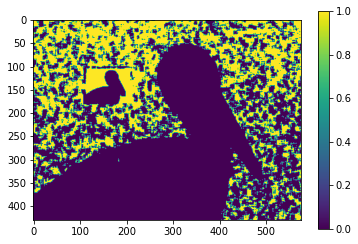

In [568]:
# filter=1
# std_r=skimage.measure.block_reduce(noise_estimate/np.sqrt(cust_m)*np.exp(-dct_var), (filter,filter), np.mean)
plt.imshow(dct_var<1)
plt.colorbar()

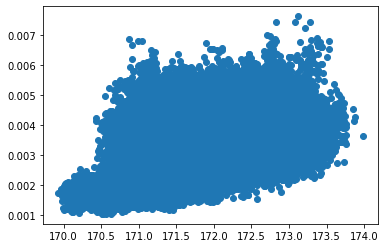

In [571]:
nois_r = noise_estimate*np.exp(-dct_var)/cust_m
filter=8
std_r=skimage.measure.block_reduce(nois_r, (filter,filter), np.mean)
# plt.imshow(std_r)

Lx=[]
Ly=[]
n,m = noise_estimate.shape
for i in range(n):
    for j in range(m):
        if dct_var[i,j]<1 and cust_m[i,j]<200:
            Ly.append(noise_estimate[i,j]/(cust_m[i,j]))
            Lx.append(cust_m[i,j])
plt.plot(Lx,Ly,'o')
plt.show()

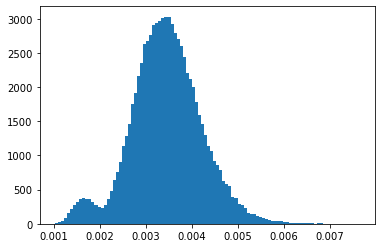

In [573]:
plt.hist(Ly,bins=100)
plt.show()